In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%tensorflow_version 1.x
import sys 
sys.path.append("/content/drive/My Drive/experiments")
import uuid
from train.config import batchsize,frames_per_seq, h, w, opt,train_samples_per_epoch,val_samples_per_epoch,nb_epochs,dreyeve_train_seq,train_frame_range,dreyeve_dir
from train.config import full_frame_loss, crop_loss, w_loss_fine, w_loss_cropped,simo_mode
from train.batch_generators import generate_dreyeve_I_batch, generate_dreyeve_OF_batch, generate_dreyeve_SEG_batch,dreyeve_I_batch,sample_signature
from train.batch_generators import generate_dreyeve_batch,load_saliency_data
from train.models import DreyeveNet,SaliencyBranch
from train.loss_functions import saliency_loss
from train.callbacks import get_callbacks
from computer_vision_utils.io_helper import read_image, normalize
from tqdm import  tqdm
import numpy as np
from os.path import join
import cv2
from computer_vision_utils.tensor_manipulation import resize_tensor


TensorFlow 1.x selected.


Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1.15.2


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def fine_tuning():
    """
    Function to launch training on DreyeveNet. It is called `fine_tuning` since supposes
    the three branches to be pretrained. Should also work from scratch.
    """

    experiment_id = 'DREYEVE_{}'.format(uuid.uuid4())

    model = DreyeveNet(frames_per_seq=frames_per_seq, h=h, w=w)
    model.compile(optimizer=opt,
                  loss={'prediction_fine': saliency_loss(name=full_frame_loss),
                        'prediction_crop': saliency_loss(name=crop_loss)},
                  loss_weights={'prediction_fine': w_loss_fine,
                                'prediction_crop': w_loss_cropped})
    model.summary()

    model.fit_generator(generator=generate_dreyeve_batch(batchsize=batchsize, nb_frames=frames_per_seq,
                                                         image_size=(h, w), mode='train'),
                        validation_data=generate_dreyeve_batch(batchsize=batchsize, nb_frames=frames_per_seq,
                                                               image_size=(h, w), mode='val'),
                        nb_val_samples=val_samples_per_epoch,
                        samples_per_epoch=train_samples_per_epoch,
                        nb_epoch=nb_epochs,
                        callbacks=get_callbacks(experiment_id=experiment_id))



In [0]:
def train_image_branch():
    
    """
    Function to train a SaliencyBranch model on images.
    """

    experiment_id = 'COLOR_{}'.format(uuid.uuid4())

    model = SaliencyBranch(input_shape=(frames_per_seq, h, w,3), c3d_pretrained=True, branch='image')
    
    model.compile(optimizer=opt,
                  loss={'prediction_fine': saliency_loss(name=full_frame_loss),
                        'prediction_crop': saliency_loss(name=crop_loss)},
                  loss_weights={'prediction_fine': w_loss_fine,
                                'prediction_crop': w_loss_cropped})
    model.load_weights("/content/drive/My Drive/dreyeve project (my file)/Train/checkpoints/9/w9.h5")
    model.summary()
    
    model.fit_generator(generator=generate_dreyeve_I_batch(batchsize=batchsize, nb_frames=frames_per_seq,
                                                           image_size=(h, w), mode='train'),
                        validation_data=generate_dreyeve_I_batch(batchsize=batchsize, nb_frames=frames_per_seq,
                                                                 image_size=(h, w), mode='val'),
                        nb_val_samples=val_samples_per_epoch,
                        samples_per_epoch=train_samples_per_epoch,
                        nb_epoch=nb_epochs,
                        callbacks=get_callbacks(experiment_id=experiment_id)
                        )
    
    

def train_flow_branch():
    """
    Function to train a SaliencyBranch model on optical flow.
    """
    experiment_id = 'FLOW_{}'.format(uuid.uuid4())

    model = SaliencyBranch(input_shape=(3, frames_per_seq, h, w), c3d_pretrained=True, branch='flow')
    model.compile(optimizer=opt,
                  loss={'prediction_fine': saliency_loss(name=full_frame_loss),
                        'prediction_crop': saliency_loss(name=crop_loss)},
                  loss_weights={'prediction_fine': w_loss_fine,
                                'prediction_crop': w_loss_cropped})
    model.summary()

    model.fit_generator(generator=generate_dreyeve_OF_batch(batchsize=batchsize, nb_frames=frames_per_seq,
                                                            image_size=(h, w), mode='train'),
                        validation_data=generate_dreyeve_OF_batch(batchsize=batchsize, nb_frames=frames_per_seq,
                                                                  image_size=(h, w), mode='val'),
                        nb_val_samples=val_samples_per_epoch,
                        samples_per_epoch=train_samples_per_epoch,
                        nb_epoch=nb_epochs,
                        callbacks=get_callbacks(experiment_id=experiment_id))


def train_seg_branch():
    """
    Function to train a SaliencyBranch model on semantic segmentation.
    """

    experiment_id = 'SEGM_{}'.format(uuid.uuid4())

    model = SaliencyBranch(input_shape=(19, frames_per_seq, h, w), c3d_pretrained=False, branch='semseg')
    
    model.compile(optimizer=opt,
                  loss={'prediction_fine': saliency_loss(name=full_frame_loss),
                        'prediction_crop': saliency_loss(name=crop_loss)},
                  loss_weights={'prediction_fine': w_loss_fine,
                                'prediction_crop': w_loss_cropped})
    model.summary()

    model.fit_generator(generator=generate_dreyeve_SEG_batch(batchsize=batchsize, nb_frames=frames_per_seq,
                                                             image_size=(h, w), mode='train'),
                        validation_data=generate_dreyeve_SEG_batch(batchsize=batchsize, nb_frames=frames_per_seq,
                                                                   image_size=(h, w), mode='val'),
                        nb_val_samples=val_samples_per_epoch,
                        samples_per_epoch=train_samples_per_epoch,
                        nb_epoch=nb_epochs,
                        callbacks=get_callbacks(experiment_id=experiment_id))


In [0]:
if __name__ == '__main__':

    branch="image"  
    assert branch in ['finetuning', 'image', 'flow', 'seg']

    if branch == 'image':
        train_image_branch()
    elif branch == 'flow':
        train_flow_branch()
    elif branch == 'seg':
        train_seg_branch()
    else:
        fine_tuning()

Model: "image_saliency_branch"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input_small (InputLayer)  (None, 16, 112, 112, 0                                            
__________________________________________________________________________________________________
image_coarse_model (Model)      (None, 112, 112, 512 13499136    image_input_small[0][0]          
                                                                 image_input_crop[0][0]           
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 1)  4609        image_coarse_model[1][0]         
__________________________________________________________________________________________________
image_21x_upsampling (UpSamplin (None, 224, 224, 1)  0           conv2d_1[0][0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<generator..., validation_data=<generator..., callbacks=[<train.ca..., steps_per_epoch=5000, epochs=1, validation_steps=320)`



Epoch 1/1


/content/drive/My Drive/experiments/computer_vision_utils/io_helper.py:104: RuntimeWarning: invalid value encountered in true_divide
  img /= img.max()
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


4999/5000 [============================>.] - ETA: 6s - loss: 0.4881 - prediction_fine_loss: 0.1985 - prediction_crop_loss: 0.2896 

In [0]:
X,Y=dreyeve_I_batch(batchsize=batchsize,nb_frames=frames_per_seq,image_size=(h, w),mode='train',gt_type='sal')
print("finish")

finish


In [0]:
import os.path
from os import path
path.exists("/content/drive/My Drive/data_set/d/01/output/saliency/3350.png")

False

In [0]:
model = SaliencyBranch(input_shape=(frames_per_seq, h, w,3), c3d_pretrained=True, branch='image')
model.load_weights('/content/drive/My Drive/dreyeve project/experiments/train/checkpoints/COLOR_2544b93a-03ed-49eb-8153-704a25c144f2/w_epoch_000019.h5')  # load weights


In [0]:
def load_dreyeve_sample(sequence_dir, sample, mean_dreyeve_image, frames_per_seq=16, h=448, w=448, ):
    """
    Function to load a dreyeve_sample.

    :param sequence_dir: string, sequence directory (e.g. 'Z:/DATA/04/').
    :param sample: int, sample to load in (15, 7499). N.B. this is the sample where prediction occurs!
    :param mean_dreyeve_image: mean dreyeve image, subtracted to each frame.
    :param frames_per_seq: number of temporal frames for each sample
    :param h: h
    :param w: w
    :return: a dreyeve_sample like I, OF, SEG
    """

    h_c = h_s = h // 4
    w_c = w_s = h // 4

    I_ff = np.zeros(shape=(1, 1, h, w,3), dtype='float32')
    I_s = np.zeros(shape=(1, frames_per_seq, h_s, w_s,3), dtype='float32')
    I_c = np.zeros(shape=(1, frames_per_seq, h_c, w_c,3), dtype='float32')
    SEG_ff = np.zeros(shape=(1, 19, 1, h, w), dtype='float32')
    SEG_s = np.zeros(shape=(1, 19, frames_per_seq, h_s, w_s), dtype='float32')
    SEG_c = np.zeros(shape=(1, 19, frames_per_seq, h_c, w_c), dtype='float32')
    OF_ff = np.zeros(shape=(1, 3, 1, h, w), dtype='float32')
    OF_s = np.zeros(shape=(1, 3, frames_per_seq, h_s, w_s), dtype='float32')
    OF_c = np.zeros(shape=(1, 3, frames_per_seq, h_c, w_c), dtype='float32')
    
   
    for fr in range(0, frames_per_seq):
        offset = sample - frames_per_seq + 1 + fr   # tricky

        # read image
        x = read_image(join(sequence_dir,'frames','{}.jpg'.format(offset)),
                       channels_first=False, resize_dim=(h, w)) - mean_dreyeve_image
        I_s[0, fr, :, :,:] = resize_tensor(x,new_shape=(h_s, w_s))
        """
        # read semseg
        seg = resize_tensor(np.load(join(sequence_dir,'segmentation', '{}.npz'.format(offset)))['arr_0'][0],
                            new_shape=(h, w))
        SEG_s[0, :, fr, :, :] = resize_tensor(seg, new_shape=(h_s, w_s))
        # read of
        
        of = read_image(join(sequence_dir,'optical_flow', '{}.jpg'.format(offset + 1)),
                        channels_first=True, resize_dim=(h, w))
        of -= np.mean(of, axis=(1, 2), keepdims=True)  # remove mean
        OF_s[0, :, fr, :, :] = resize_tensor(of, new_shape=(h_s, w_s))
        """

    I_ff[0,0, :, :,:] = x
    #SEG_ff[0, :, 0, :, :] = seg
    #OF_ff[0, :, 0, :, :] = of

    return [I_ff, I_s, I_c]


In [0]:
frames_per_seq, h, w = 16, 448, 448
dreyeve_dir = '/content/drive/My Drive/dreyeve project/test_set/v48/' #heeeeeeerrrrr
# load mean dreyeve image
mean_dreyeve_image = read_image("/content/drive/My Drive/dreyeve project/test_set/v13/mean_frame.png",
                                    channels_first=False, resize_dim=(h, w))

100%|██████████| 14/14 [00:46<00:00,  3.33s/it]


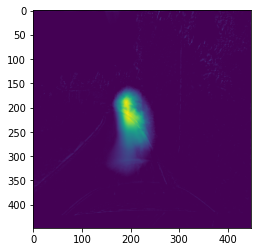

In [0]:
import matplotlib.pyplot as plt
from time import time

for sample in tqdm(range(15, 30 - 1)):        
        
        t = time()
        
        X = load_dreyeve_sample("/content/drive/My Drive/dreyeve project/test_set/v48/inputs/", sample=sample, mean_dreyeve_image=mean_dreyeve_image,
                                frames_per_seq=frames_per_seq, h=h, w=w)#heeeerrrrrr
        #Y_dreyevenet = dreyevenet_model.predict(X)[0]  # get only [fine_out][remove batch]
        Y_image = model.predict(X)[0]  # predict on image
        plt.imshow(Y_image[0,:,:,0])        
        #pl.imshow(Y_image[0,:,:,0],'gray')
        #Y_flow = flow_branch.predict(X[3:6])[0]  # predict on optical flow
        #Y_semseg = semseg_branch.predict(X[3:])[0]  # predict on segmentation
